# 영화리뷰 텍스트 감성분석하기 [프로젝트]

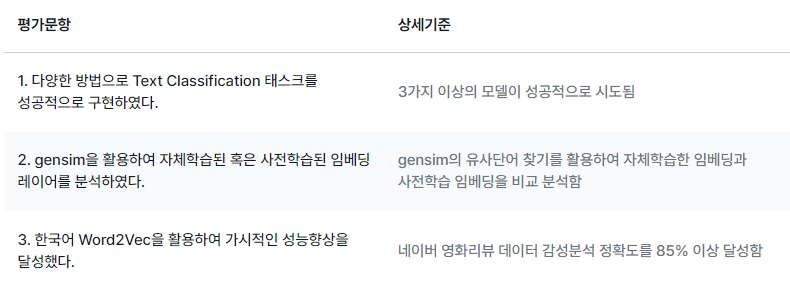

### 3가지 모델에 대해서 실험을 진행함
    - 1. Conv1D
    - 2. Only Global max pooling
    - 3. LSTM

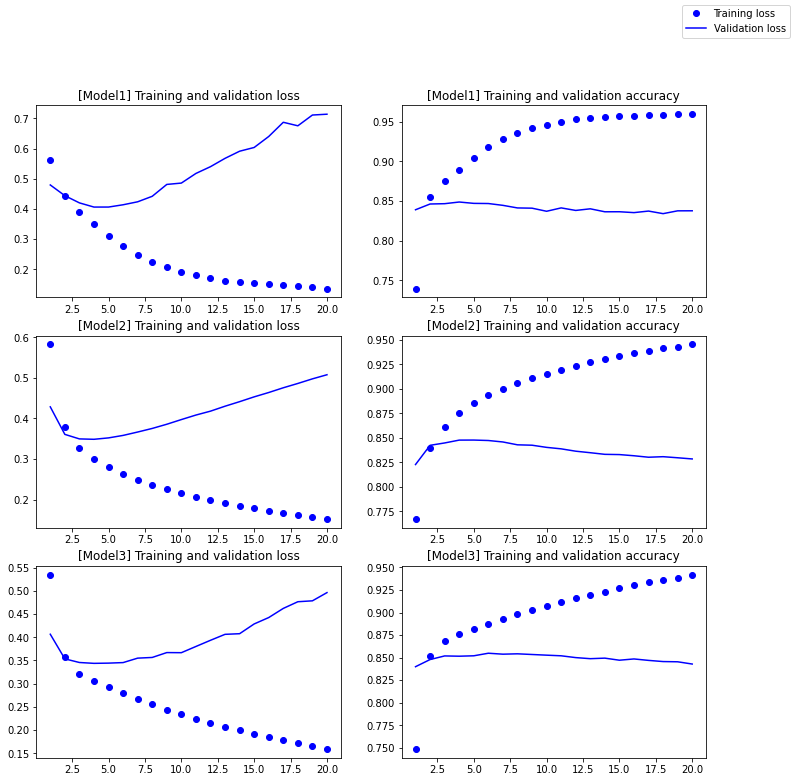




### gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.

- Model1 에서 학습된 임베딩 레이어 사랑과 연관된 단어를 보고자했는데 제대로 안된것같다

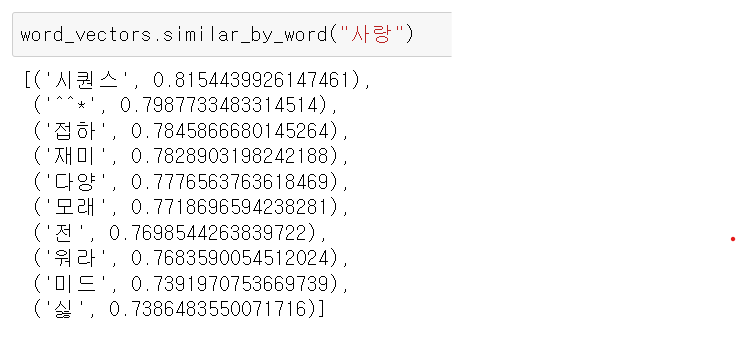


## 회고

- 오늘은 마지막에 사전학습된 임베딩 레이어를 사용해서 진행하는 코드를 만들지못했다
- 사전학습된 모델을 불러오는데 계속 실패했다. 
- 더 좋은 성능의 모델을 만드는데 집중하지못했다. -> 에포크도 적당히 돌리고 끝냈다


In [20]:
import pandas
import konlpy
import gensim

from konlpy.tag import Mecab
from collections import Counter

import numpy as np
import tensorflow as tf
import os

In [8]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [12]:
temp_X = tokenizer.morphs(train_data['document'][12])
print(temp_X)

['울', '면서', '손들', '고', '횡단', '보도', '건널', '때', '뛰쳐나올', '뻔', '이범수', '연기', '드럽', '게', '못해']


In [13]:
temp_X = [word for word in temp_X if not word in stopwords]
print(temp_X)

['울', '면서', '손들', '고', '횡단', '보도', '건널', '때', '뛰쳐나올', '뻔', '이범수', '연기', '드럽', '게', '못해']


In [26]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [28]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [29]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [30]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0
pad_sequences maxlen :  41
전체 문장의 0.0%가 maxlen 설정값 이내에 포함됩니다. 


In [32]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 오류 노트

```
word_to_index["<PAD>"]  
```
  
이 코드가 실행이 안된다  

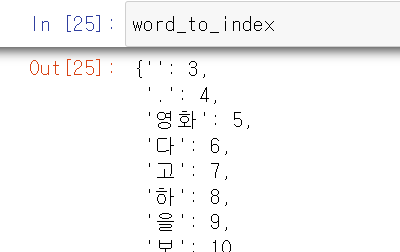
    
3번부터 시작하게 하고 <PAD등을 추가하지않았다>
    
-> load_data 함수에 추가
    -> load_data 실행시간이 너무 길어서 따로할걸그랬다..

# 4) 모델 구성 및 validation set 구성

- 14만건 정도 되니 2만개를 validation으로 사용

# 5) 모델 훈련 개시

In [39]:
# validation set 20000건 분리
X_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[20000:]
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


### 모델 1 구성 (Conv1D + MaxPooling)

In [47]:
vocab_size = len(word_to_index) # 어휘 사전의 크기입니다 - word_to_index의 길이 load_data 보면 설정해줬음 10000개로
word_vector_dim = 16   # 학습시키면서 진행할테니 - 일단 16차원으로 적어둔다

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.MaxPooling1D(5))
model1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model1.summary()

In [48]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 5s 6ms/step - loss: 0.5625 - accuracy: 0.7397 - val_loss: 0.4795 - val_accuracy: 0.8390
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.4426 - accuracy: 0.8552 - val_loss: 0.4440 - val_accuracy: 0.8463
Epoch 3/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3908 - accuracy: 0.8747 - val_loss: 0.4201 - val_accuracy: 0.8467
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3492 - accuracy: 0.8892 - val_loss: 0.4062 - val_accuracy: 0.8488
Epoch 5/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3115 - accuracy: 0.9040 - val_loss: 0.4063 - val_accuracy: 0.8471
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2767 - accuracy: 0.9178 - val_loss: 0.4138 - val_accuracy: 0.8469
Epoch 7/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2480 - accuracy: 0.9283 - val_loss: 0.4237 - val_accuracy: 0.8446
Epoch 

### 모델 2 구성 (only Global MaxPooling)

In [49]:
vocab_size = len(word_to_index) # 어휘 사전의 크기입니다 - word_to_index의 길이 load_data 보면 설정해줬음 10000개로
word_vector_dim = 16   # 학습시키면서 진행할테니 - 일단 16차원으로 적어둔다

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model2.summary()

In [50]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 1s 4ms/step - loss: 0.5820 - accuracy: 0.7675 - val_loss: 0.4284 - val_accuracy: 0.8228
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.3781 - accuracy: 0.8395 - val_loss: 0.3606 - val_accuracy: 0.8425
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.3279 - accuracy: 0.8613 - val_loss: 0.3495 - val_accuracy: 0.8449
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.2999 - accuracy: 0.8755 - val_loss: 0.3485 - val_accuracy: 0.8478
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.2797 - accuracy: 0.8856 - val_loss: 0.3520 - val_accuracy: 0.8478
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.2634 - accuracy: 0.8934 - val_loss: 0.3581 - val_accuracy: 0.8474
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.2494 - accuracy: 0.9000 - val_loss: 0.3664 - val_accuracy: 0.8458
Epoch 

### 모델 3 구성 (LSTM 1개 8차원)

In [51]:
vocab_size = len(word_to_index) # 어휘 사전의 크기입니다 - word_to_index의 길이 load_data 보면 설정해줬음 10000개로
word_vector_dim = 16   # 학습시키면서 진행할테니 - 일단 16차원으로 적어둔다

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


In [52]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 4s 7ms/step - loss: 0.5348 - accuracy: 0.7484 - val_loss: 0.4063 - val_accuracy: 0.8399
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3574 - accuracy: 0.8517 - val_loss: 0.3532 - val_accuracy: 0.8478
Epoch 3/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3214 - accuracy: 0.8685 - val_loss: 0.3454 - val_accuracy: 0.8518
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3050 - accuracy: 0.8760 - val_loss: 0.3436 - val_accuracy: 0.8515
Epoch 5/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2920 - accuracy: 0.8816 - val_loss: 0.3441 - val_accuracy: 0.8519
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2788 - accuracy: 0.8877 - val_loss: 0.3452 - val_accuracy: 0.8548
Epoch 7/20
247/247 [==============================] - 1s 6ms/step - loss: 0.2666 - accuracy: 0.8928 - val_loss: 0.3548 - val_accuracy: 0.8537
Epoch 

### 모델 4 구성 (Transformer 1개 8차원) - 구현중

In [53]:
vocab_size = len(word_to_index) # 어휘 사전의 크기입니다 - word_to_index의 길이 load_data 보면 설정해줬음 10000개로
word_vector_dim = 16   # 학습시키면서 진행할테니 - 일단 16차원으로 적어둔다

model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model4.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


In [54]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 3s 7ms/step - loss: 0.5212 - accuracy: 0.7727 - val_loss: 0.3749 - val_accuracy: 0.8424
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3466 - accuracy: 0.8545 - val_loss: 0.3507 - val_accuracy: 0.8478
Epoch 3/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3208 - accuracy: 0.8667 - val_loss: 0.3460 - val_accuracy: 0.8502
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 0.3082 - accuracy: 0.8729 - val_loss: 0.3487 - val_accuracy: 0.8513
Epoch 5/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2992 - accuracy: 0.8760 - val_loss: 0.3459 - val_accuracy: 0.8511
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2903 - accuracy: 0.8804 - val_loss: 0.3468 - val_accuracy: 0.8536
Epoch 7/20
247/247 [==============================] - 1s 5ms/step - loss: 0.2815 - accuracy: 0.8847 - val_loss: 0.3512 - val_accuracy: 0.8504
Epoch 

## 평가

순서대로 1,2,3
-> 비슷비슷하다

- 1. CNN
- 2. Only Global max pooling
- 3. LSTM

- 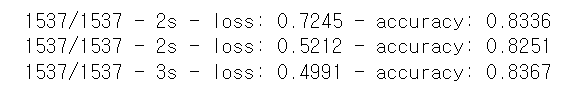

In [74]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)
results2 = model2.evaluate(X_test,  y_test, verbose=2)
results3 = model3.evaluate(X_test,  y_test, verbose=2)
results4 = model4.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 2s - loss: 0.7245 - accuracy: 0.8336
1537/1537 - 2s - loss: 0.5212 - accuracy: 0.8251
1537/1537 - 3s - loss: 0.4991 - accuracy: 0.8367
1537/1537 - 3s - loss: 0.4604 - accuracy: 0.8430
[0.7245030403137207, 0.8336350917816162]


# 6) Loss, Accuracy 그래프 시각화

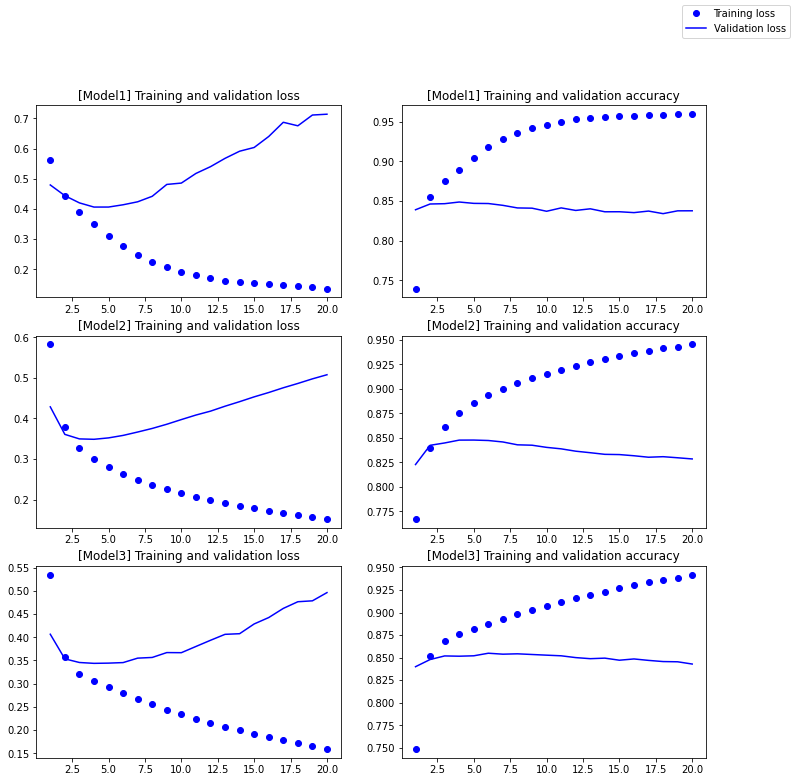

In [83]:
history_dict1 = history1.history
history_dict2 = history2.history
history_dict3 = history3.history
history_dict4 = history4.history

import matplotlib.pyplot as plt

acc1 = history_dict1['accuracy']
acc2 = history_dict2['accuracy']
acc3 = history_dict3['accuracy']
acc4 = history_dict4['accuracy']

val_acc1 = history_dict1['val_accuracy']
val_acc2 = history_dict2['val_accuracy']
val_acc3 = history_dict3['val_accuracy']
val_acc4 = history_dict4['val_accuracy']

loss1 = history_dict1['loss']
loss2 = history_dict2['loss']
loss3 = history_dict3['loss']
loss4 = history_dict4['loss']

val_loss1 = history_dict1['val_loss']
val_loss2 = history_dict2['val_loss']
val_loss3 = history_dict3['val_loss']
val_loss4 = history_dict4['val_loss']

epochs = range(1, len(acc1) + 1)

fig, axs = plt.subplots(3,2, figsize = (12,12))

axs[0,0].plot(epochs, loss1, 'bo', label='Training loss')
axs[0,0].plot(epochs, val_loss1, 'b', label='Validation loss')
axs[0,0].set_title('[Model1] Training and validation loss')

axs[0,1].plot(epochs, acc1, 'bo')
axs[0,1].plot(epochs, val_acc1, 'b')
axs[0,1].set_title('[Model1] Training and validation accuracy')

axs[1,0].plot(epochs, loss2, 'bo')
axs[1,0].plot(epochs, val_loss2, 'b')
axs[1,0].set_title('[Model2] Training and validation loss')

axs[1,1].plot(epochs, acc2, 'bo')
axs[1,1].plot(epochs, val_acc2, 'b')
axs[1,1].set_title('[Model2] Training and validation accuracy')

axs[2,0].plot(epochs, loss3, 'bo')
axs[2,0].plot(epochs, val_loss3, 'b')
axs[2,0].set_title('[Model3] Training and validation loss')

axs[2,1].plot(epochs, acc3, 'bo')
axs[2,1].plot(epochs, val_acc3, 'b')
axs[2,1].set_title('[Model3] Training and validation accuracy')

fig.legend()

# 7) 학습된 Embedding 레이어 분석

In [76]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_model1.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [78]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['나']
vector

array([-0.04698365, -0.0251187 , -0.04900324, -0.03389881,  0.02341619,
        0.00952109,  0.03644817,  0.03468938,  0.03502673, -0.0085309 ,
        0.00536742,  0.01115692,  0.03520543,  0.00250013, -0.02710936,
        0.00495361], dtype=float32)

In [79]:
word_vectors.similar_by_word("사랑")

[('시퀀스', 0.8154439926147461),
 ('^^*', 0.7987733483314514),
 ('접하', 0.7845866680145264),
 ('재미', 0.7828903198242188),
 ('다양', 0.7776563763618469),
 ('모래', 0.7718696594238281),
 ('전', 0.7698544263839722),
 ('워라', 0.7683590054512024),
 ('미드', 0.7391970753669739),
 ('싫', 0.7386483550071716)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [89]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '~/data/word2vec_ko.model'

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

FileNotFoundError: [Errno 2] No such file or directory: '~/data/word2vec_ko.model.wv.vectors.npy'